In [2]:
%%capture
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from tensorflow.keras import layers, utils, losses, models as mds, optimizers
from visualkeras import layered_view

if imp.find_loader('aggdraw'): import aggdraw
if imp.find_loader('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers

2022-03-17 11:26:39.399913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-17 11:26:39.399979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
IMG_SIZE = 264
N_CLASSES = 102

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 264, 264, 3)]     0         
                                                                 
 conv_block_0 (Sequential)   (None, 66, 66, 32)        1024      
                                                                 
 conv_block_1 (Sequential)   (None, 16, 16, 64)        18752     
                                                                 
 conv_block_2 (Sequential)   (None, 4, 4, 96)          55776     
                                                                 
 conv_block_3 (Sequential)   (None, 1, 1, 160)         139040    
                                                                 
 dense_45 (Dense)            (None, 1, 1, 60)          9660      
                                                                 
 flatten_14 (Flatten)        (None, 60)                0  

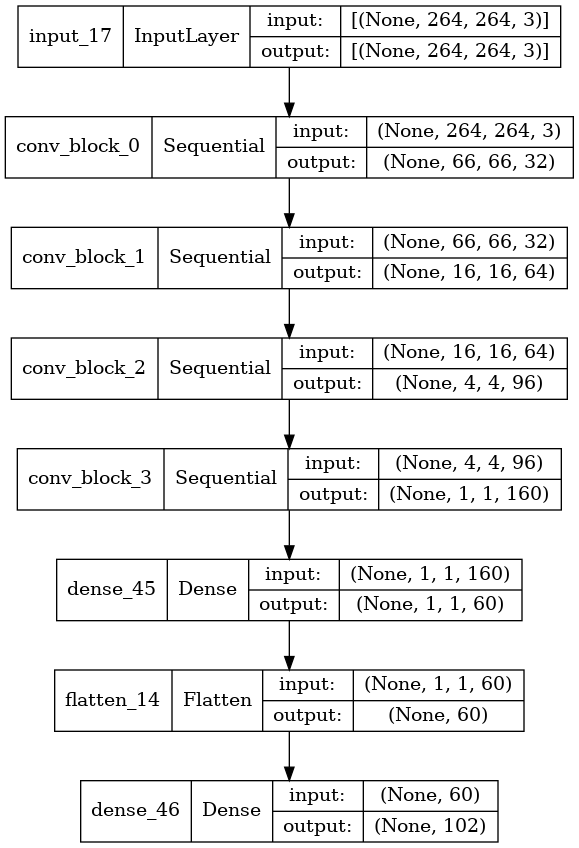

In [84]:
conv_id = -1

def increment_conv_id():
    global conv_id
    conv_id += 1

    return conv_id

def conv_block(filters, strides=1, **kwargs):
    return tf.keras.Sequential([
            layers.Conv2D(filters, 3, strides=strides, **kwargs),
            layers.MaxPool2D(strides) if strides > 1 else None,
            layers.Dropout(0.2),
            layers.BatchNormalization()
        ],
        name='conv_block_' + str(increment_conv_id()))

def attentive_merge(q, v):
    v = layers.Dense(q.shape[-1])(v) if v.shape[-1] != q.shape[-1] else v
    return layers.Attention()([q, v])

def multi_level_merge(q, vs):
    format = lambda t: layers.Reshape([-1, t.shape[-1]])(t)
    unformat = lambda t,s: layers.Reshape(s[1:])(t)

    # output = reduce(lambda y,x: layers.Attention()([y, format(x)]), qs, format(v))
    output = reduce(lambda y,x: attentive_merge(y, format(x)), vs, format(q))

    v = unformat(output, q.shape)
    return v

class Fibo(object):
    def __init__(self, first, second, limit=None):
        self.first = first
        self.second = second
        self.limit = limit
    
    def next(self):
        v = self.first + self.second
        limit_cond = self.limit and v < self.limit
        self.first, self.second = (self.second, v) if limit_cond else (self.second, self.limit)
        return self.second
    
    def get(self):
        return self.second

"""
Heat indicates a conv down operation. Chill follows heat convs to preserve the spatial dimensions.
Reheat is a conv up operation which follows chill convs.
"""
def assemble_backbone(input_tensor, depth, skip_rates, skip_start_depth,
    heat=1, chill=1, reheat=8,
    min_channels=32, max_channels=1024
):
    channel_fibo = Fibo(0, min_channels, max_channels)
    channel_fn = lambda: min(channel_fibo.next(), max_channels)
    conf_fn = lambda x: (2, channel_fn()) if x%(heat+chill) == 0 else (1, channel_fibo.get())

    # strides = list(map(lambda x: 2 if x%(heat+chill) == 0 else 1, range(depth)))
    confs = list(map(conf_fn, range(depth)))

    # Create Convolution Blocks
    kwargs = dict(padding='same', activation='relu')
    blocks = list(map(lambda x: conv_block(x[1], strides=x[0], **kwargs), confs))
    block_outputs = [None] * len(blocks)

    # Compute skip connections
    skip_levels = list(map(lambda sr: list(range(0, depth, sr)), skip_rates))
    skip_connections = [[] for _ in range(depth)]

    for sl in skip_levels:
        for x in range(1, len(sl)):
            skip_connections[sl[x]].append(sl[x-1])

    def join_skips(idx, skips):
        skip_outputs = list(map(lambda x: block_outputs[x], skips))
        block_input =  multi_level_merge(block_outputs[idx-1], skip_outputs)
        return blocks[idx](block_input)
    
    def apply_reheat(idx, x):
        filters, name = x.shape[-1], 'conv_transpose_' + str(increment_conv_id())
        x = layers.Conv2DTranspose(filters, 3, strides=2, name=name)(x)
        block_outputs[idx-1] = x
        return x
    
    for idx, block in enumerate(blocks):
        skips = skip_connections[idx]

        # Deconv to increase dimensionality
        reheat_cond = reheat and idx and not idx%reheat
        input_tensor = apply_reheat(idx, input_tensor) if reheat_cond else input_tensor

        join_cond = skips and idx >= skip_start_depth
        input_tensor = join_skips(idx, skips) if join_cond else block(input_tensor)
        block_outputs[idx] = input_tensor
    
    return input_tensor
    
def create_model(depth=60, skips=[2, 3, 5, 8, 13, 21, 34, 55], skip_start_depth=9, **kwargs):
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = assemble_backbone(inp, depth, skips, skip_start_depth, **kwargs)
    x = layers.Dense(60, activation='relu')(x)
    x = layers.Flatten()(x)
    output = layers.Dense(N_CLASSES, activation='softmax')(x)

    m = tf.keras.Model(inputs=inp, outputs=output)
    optimizer = optimizers.Nadam()

    m.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='accuracy')

    return m

kwargs = dict(heat=1, chill=0, reheat=0, min_channels=32, max_channels=256)
model = create_model(depth=4, skips=[], skip_start_depth=2, **kwargs)
model.summary()
utils.plot_model(model, show_shapes=True)

In [29]:
augs = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
])

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block_0 (Sequential)      (None, 132, 132, 64  2048        ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 conv_block_1 (Sequential)      (None, 132, 132, 64  37184       ['conv_block_0[0][0]']           
                                )                                                           

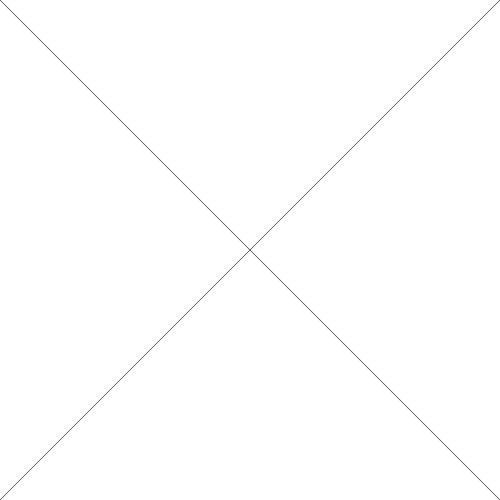

In [42]:
class Fibo(object):
    def __init__(self, first, second):
        self.first = first
        self.second = second
    
    def next(self):
        v = self.first + self.second
        self.first, self.second = self.second, v
        return v
    
    def get(self):
        return self.second

fibo = Fibo(1, 1)
fibo.next(), fibo.next(), fibo.get()

(2, 3, 3)

In [28]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 264, 264, 3)]     0         
                                                                 
 conv_block_0 (Sequential)   (None, 132, 132, 32)      896       
                                                                 
 conv_block_1 (Sequential)   (None, 66, 66, 64)        18496     
                                                                 
 conv_block_2 (Sequential)   (None, 33, 33, 96)        55392     
                                                                 
 conv_block_3 (Sequential)   (None, 16, 16, 160)       138400    
                                                                 
 dense_27 (Dense)            (None, 16, 16, 2048)      329728    
                                                                 
 flatten_6 (Flatten)         (None, 524288)            0   

In [82]:
def model_summary(m, level=1):
    l_names, l_shapes, l_levels, l_params = [], [], [], []
    name_indent = 2

    def indented(name, level):
        return ' '*(name_indent*level) + name
    
    def indented_line(name, level, max_len):
        name = indented(name, level)
        name += ' '*(max_len-len(name))
        return name
    
    def count_weights(ws):
        return np.sum([np.prod(w.get_shape()) for w in ws]).astype(int)

    def summary(m, level):
        for l in m.layers:
            l_names.append(l.name + ' ({})'.format(l.__class__.__name__))
            l_shapes.append(l.output_shape)
            l_levels.append(level)
            l_params.append(count_weights(l.trainable_weights) + count_weights(l.non_trainable_weights))
            summary(l, level+1) if hasattr(l, 'layers') else None
        
        longest_name_len = max(map(lambda x: len(x[0]) + name_indent*x[1], zip(l_names, l_levels)))
        longest_shape_len = max(map(lambda x: name_indent + len(str(x)), l_shapes))
        longest_param_len = max(map(lambda x: name_indent + len(str(x)), l_params))

        return longest_name_len, longest_shape_len, longest_param_len
    
    longest_name_len, longest_shape_len, longest_param_len = summary(m, level)
    line_len = longest_name_len+longest_shape_len+longest_param_len

    indented_names = list(map(lambda x: indented_line(x[0], x[1], longest_name_len), zip(l_names, l_levels)))
    indented_shapes = list(map(lambda x: indented_line(str(x), 1, longest_shape_len), l_shapes))

    total_trainable = count_weights(m.trainable_weights)
    total_non_trainable = count_weights(m.non_trainable_weights)

    print(' '*name_indent, 'Model: ', model.name)
    print('_'*line_len)
    #Layer (type)                Output Shape              Param #  
    print(
        indented_line('Layer (type)', 1, longest_name_len),
        indented_line('Output Shape', 1, longest_shape_len),
        indented_line('Param #', 0, longest_param_len)
    )
    print('='*line_len)
    for name, shape, params in zip(indented_names, indented_shapes, l_params):
        print(name, shape, params)
        print()
    print('='*line_len)
    print('Total params: {:,}'.format(total_trainable + total_non_trainable))
    print('Trainable params: {:,}'.format(total_trainable))
    print('Non-trainable params: {:,}'.format(total_non_trainable))
    print('_'*line_len)

model_summary(model)


   Model:  model_11
_______________________________________________________________________________
  Layer (type)                                     Output Shape          Param # 
  input_15 (InputLayer)                            [(None, 264, 264, 3)] 0

  conv_block_0 (Sequential)                        (None, 66, 66, 32)    1024

    conv2d_177 (Conv2D)                            (None, 132, 132, 32)  896

    max_pooling2d_42 (MaxPooling2D)                (None, 66, 66, 32)    0

    dropout_74 (Dropout)                           (None, 66, 66, 32)    0

    batch_normalization_134 (BatchNormalization)   (None, 66, 66, 32)    128

  conv_block_1 (Sequential)                        (None, 16, 16, 64)    18752

    conv2d_178 (Conv2D)                            (None, 33, 33, 64)    18496

    max_pooling2d_43 (MaxPooling2D)                (None, 16, 16, 64)    0

    dropout_75 (Dropout)                           (None, 16, 16, 64)    0

    batch_normalization_135 (BatchNormaliza